In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def exact_solution(d, w0, t):
    # 定义欠阻尼谐振子问题的解析解
    assert d < w0  # 确保阻尼系数d小于自然频率w0
    w = np.sqrt(w0**2 - d**2)  # 计算欠阻尼频率
    phi = np.arctan(-d/w)  # 计算初始相位
    A = 1/(2*np.cos(phi))  # 计算振幅
    cos = torch.cos(phi + w * t)  # 计算余弦项
    exp = torch.exp(-d * t)  # 计算指数衰减项
    u = exp * 2 * A * cos  # 计算解
    return u

class FCN(nn.Module):
    # 定义一个全连接神经网络（FCN）类
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh  # 使用双曲正切作为激活函数
        # 第一层全连接层，从输入层到隐藏层
        self.fcs = nn.Sequential(*[                     #   第一层的结构可以根据实际情况进行调整
                        nn.Linear(N_INPUT, N_HIDDEN),       #   全连接层的输入和输出维度相同
                        activation()])                      #   激活函数为双曲正切  
        # 中间隐藏层，可能有多层
        self.fch = nn.Sequential(*[                      #   隐藏层的结构可以根据实际情况进行调整
                        nn.Sequential(*[                     #   每一层由一个全连接层和激活函数构成
                            nn.Linear(N_HIDDEN, N_HIDDEN),       #   全连接层的输入和输出维度相同
                            activation()]) for _ in range(N_LAYERS-1)])      #   隐藏层的层数由参数N_LAYERS决定
        # 最后一层全连接层，从隐藏层到输出层
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        # 定义网络的前向传播过程
        x = self.fcs(x)  # 通过第一层全连接层
        x = self.fch(x)  # 通过中间隐藏层
        x = self.fce(x)  # 通过最后一层全连接层
        return x


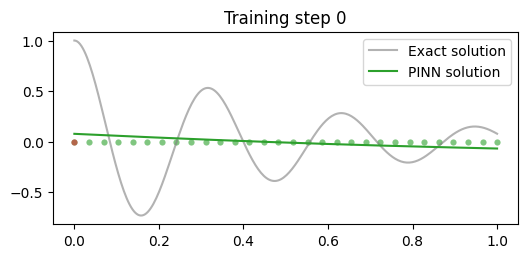

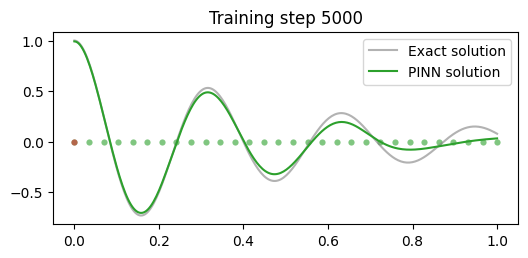

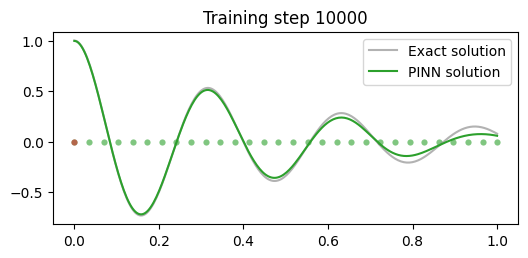

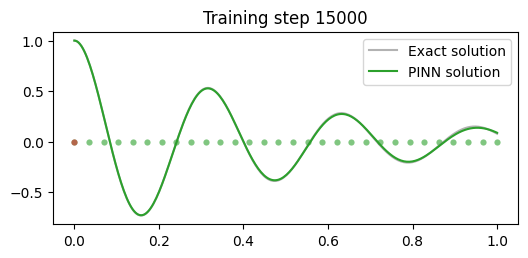

In [15]:
torch.manual_seed(123)  # 设置随机种子以确保实验可重复性

# 定义一个神经网络用于训练
pinn = FCN(1, 1, 32, 3)  # 创建一个输入和输出都是1维，有3个隐藏层，每层32个神经元的全连接网络

# 定义边界点，用于边界损失计算
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)  # 创建一个单元素张量，值为0，形状为(1, 1)，需要计算梯度

# 定义域上的训练点，用于物理损失计算
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)  # 创建一个从0到1等间隔的30个点的张量，形状为(30, 1)，需要计算梯度

# 训练过程
d, w0 = 2, 20  # 定义某些物理参数
mu, k = 2 * d, w0 ** 2  # 根据给定的物理参数计算mu和k
t_test = torch.linspace(0, 1, 300).view(-1, 1)  # 创建一个测试点集，用于最后的可视化
u_exact = exact_solution(d, w0, t_test)  # 计算精确解，用于与PINN解进行对比
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)  # 使用Adam优化器

for i in range(15001):
    optimiser.zero_grad()  # 在每次迭代开始时清空梯度

    # 计算每项损失
    lambda1, lambda2 = 1e-1, 1e-4  # 设置损失函数中的超参数

    # 计算边界损失
    u = pinn(t_boundary)  # 使用神经网络计算边界点的输出
    loss1 = (torch.squeeze(u) - 1) ** 2  # 计算边界损失的第一部分
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]  # 计算边界点输出的时间导数
    loss2 = (torch.squeeze(dudt) - 0) ** 2  # 计算边界损失的第二部分

    # 计算物理损失
    u = pinn(t_physics)  # 使用神经网络计算物理点的输出
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]  # 计算物理点输出的时间导数
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]  # 计算物理点输出的二阶时间导数
    loss3 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)  # 计算物理损失

    # 反向传播并更新参数
    loss = loss1 + lambda1 * loss2 + lambda2 * loss3  # 计算总损失
    loss.backward()  # 反向传播
    optimiser.step()  # 更新网络参数

    # 每隔5000步绘制和展示训练结果
    if i % 5000 == 0: 
    # 使用训练好的神经网络 pinn 对测试点 t_test 进行预测，并使用 .detach() 从当前计算图中分离，便于后续处理
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
    # 在图表上以绿色散点图的形式绘制物理训练点，这些点的 y 值被设置为0，使其在x轴上显示
        plt.scatter(t_physics.detach()[:,0], 
                torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
    # 以类似的方式，以红色散点图的形式绘制边界训练点
        plt.scatter(t_boundary.detach()[:,0], 
                torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
    # 绘制精确解（如果可用）作为参考，通常用于比较神经网络的输出和理论上的精确解
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
    # 绘制神经网络预测的解决方案，以展示其在测试点上的表现
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

True value of mu: 4


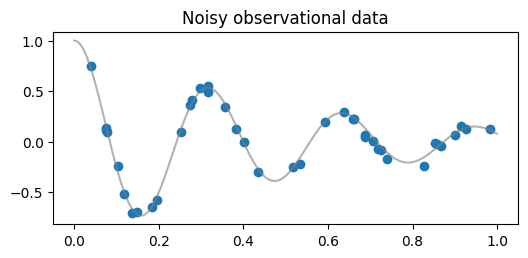

In [16]:
# 首先，创建一些带噪声的观测数据
torch.manual_seed(123)  # 设置随机种子，以确保结果的可重复性

d, w0 = 2, 20  # 定义两个变量 d 和 w0
print(f"True value of mu: {2*d}")  # 打印变量 mu 的真实值，这里 mu 被设置为 2*d

t_obs = torch.rand(40).view(-1, 1)  # 生成40个随机观测时间点，值在0到1之间
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)  # 生成观测数据。这里首先计算每个时间点的精确解，然后添加高斯噪声
t_test = torch.linspace(0, 1, 300).view(-1, 1)  # 创建300个均匀分布的测试时间点，用于绘制精确解
u_exact = exact_solution(d, w0, t_test)  # 计算测试时间点上的精确解

plt.figure(figsize=(6, 2.5))
plt.title("Noisy observational data")
plt.scatter(t_obs[:, 0], u_obs[:, 0])  # 以散点图的形式绘制带噪声的观测数据
plt.plot(t_test[:, 0], u_exact[:, 0], label="Exact solution", color="tab:grey", alpha=0.6)  # 绘制精确解的曲线，用于对比
plt.show()

<>:60: SyntaxWarning: invalid escape sequence '\m'
<>:60: SyntaxWarning: invalid escape sequence '\m'
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_65092/3548129637.py:60: SyntaxWarning: invalid escape sequence '\m'
  plt.title("$\mu$")


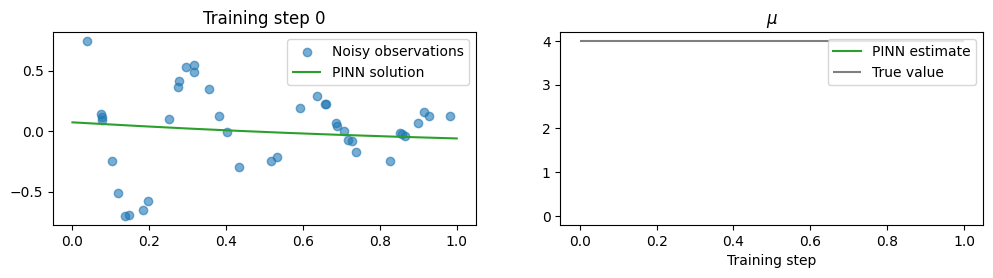

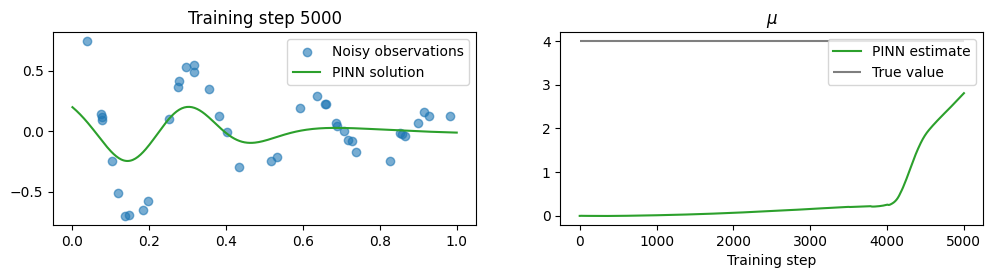

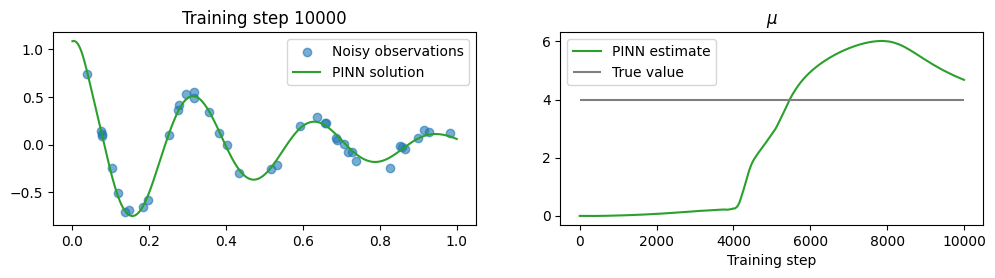

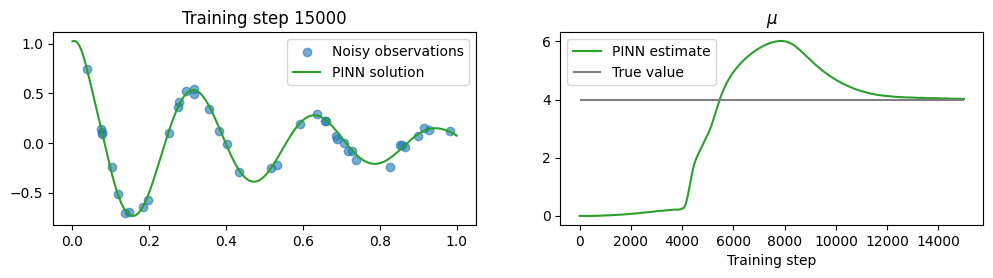

In [19]:
torch.manual_seed(123)  # 设置随机种子以确保结果可重复

# 定义一个神经网络用于训练
pinn = FCN(1, 1, 32, 3)  # 初始化一个具有1个输入和1个输出，32个神经元，3个隐藏层的全连接网络

# 定义整个域上的训练点，用于计算物理损失
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)  # 创建一个从0到1的30个均匀分布的点，形状为(30, 1)，需要计算梯度

# 训练PINN
d, w0 = 2, 20  # 定义物理参数
_, k = 2 * d, w0 ** 2  # 计算另一个物理参数 k
t_test = torch.linspace(0, 1, 300).view(-1, 1)  # 创建300个测试点
u_exact = exact_solution(d, w0, t_test)  # 计算精确解

# ！！！！！！！！
# 将 mu 视为可学习参数，并添加到优化器，这个是重点
# ！！！！！！！！
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))  # 初始化 mu 参数
optimiser = torch.optim.Adam(list(pinn.parameters()) + [mu], lr=1e-3)  # 创建一个优化器，包含网络参数和 mu
mus = []  # 用于记录 mu 的值

for i in range(15001):
    optimiser.zero_grad()  # 清除旧的梯度

    # 计算物理损失
    u = pinn(t_physics)  # 网络在物理点的输出
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]  # 输出的一阶导数
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]  # 输出的二阶导数
    loss1 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)  # 计算物理损失

    # 计算数据损失
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs) ** 2)  # 计算观测数据的损失
    
    # 计算每项损失
    lambda1, lambda2 = 1e4, 1e-4  # 设置损失函数中的超参数

    # 反向传播总损失，更新优化器
    loss = loss1 + lambda1 * loss2
    loss.backward()
    optimiser.step()

    # 记录 mu 的值
    mus.append(mu.item())

    # 训练进度的可视化
    if i % 5000 == 0:
        u = pinn(t_test).detach()  # 计算测试点上的网络输出
        plt.figure(figsize=(12, 2.5))

        # 绘制观测数据和PINN解
        plt.subplot(1, 2, 1)
        plt.scatter(t_obs[:, 0], u_obs[:, 0], label="Noisy observations", alpha=0.6, color="tab:blue")
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()

        # 绘制 mu 的估计值
        plt.subplot(1, 2, 2)
        plt.title("$\mu$")
        plt.plot(mus, label="PINN estimate", color="tab:green")
        plt.hlines(2 * d, 0, len(mus), label="True value", color="tab:grey")
        plt.xlabel("Training step")
        plt.legend()

        plt.show()